In [5]:
# # Google Colab specific
# %cd ~/../content
# !rm -rf openet

# !git clone https://github.com/aetriusgx/openet.git
# %cd openet

# Data Preparation

In [6]:
from datetime import datetime
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import geopandas as gpd
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

sns.set_theme()

In [7]:
historical = pd.read_csv('./data/monterey_historical.csv', low_memory=False)
historical['time'] = pd.to_datetime(historical['time'])
historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2307897 entries, 0 to 2307896
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   time         datetime64[ns]
 1   actual_et    float64       
 2   field_id     object        
 3   crop         int64         
 4   actual_eto   float64       
 5   actual_etof  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 105.6+ MB


A table is generated that contains all forecasts for the county.

In [8]:
# Gather current forecast data for the county
forecasting_table = pd.DataFrame()
files = Path(f"data/forecasts/monterey/").glob("*.csv")

for file in files:
    # splits into [$date, 'forecast.csv']
    parts = str(file.name).split("_")
    data = pd.read_csv(file, low_memory=False)
    data["forecasting_date"] = parts[0]
    forecasting_table = pd.concat([data, forecasting_table], ignore_index=True)

forecasting_table['forecasting_date'] = pd.to_datetime(forecasting_table['forecasting_date'])
forecasting_table['time'] = pd.to_datetime(forecasting_table['time'])
forecasting_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384694 entries, 0 to 8384693
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   field_id          object        
 1   crop              int64         
 2   time              datetime64[ns]
 3   expected_et       float64       
 4   expected_eto      float64       
 5   expected_etof     float64       
 6   forecasting_date  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 447.8+ MB


In [9]:
dt = historical.loc[(historical['time'].dt.year == 2024), :]
dt = dt.merge(forecasting_table, on=['field_id', 'time', 'crop'], how='right').set_index(['forecasting_date', 'field_id', 'crop', 'time']).reset_index()
dt

,forecasting_date,field_id,crop,time,actual_et,actual_eto,actual_etof,expected_et,expected_eto,expected_etof
0,2024-07-29,CA_244000,47,2024-01-01,0.718,1.103,0.650,0.718,1.103,0.650
1,2024-07-29,CA_244000,47,2024-01-02,0.668,1.018,0.656,0.668,1.018,0.656
2,2024-07-29,CA_244000,47,2024-01-03,1.403,2.122,0.661,1.403,2.122,0.661
3,2024-07-29,CA_244000,47,2024-01-04,1.698,2.546,0.667,1.698,2.546,0.667
4,2024-07-29,CA_244000,47,2024-01-05,1.027,1.528,0.672,1.027,1.528,0.672
...,...,...,...,...,...,...,...,...,...,...
8384689,2024-01-01,CA_251078,61,2024-01-05,0.339,1.292,0.262,0.175,1.650,0.106
8384690,2024-01-01,CA_251078,61,2024-01-04,0.461,1.846,0.250,0.184,1.714,0.108
8384691,2024-01-01,CA_251078,61,2024-01-03,0.307,1.292,0.237,0.187,1.708,0.110
8384692,2024-01-01,CA_251078,61,2024-01-02,0.104,0.462,0.225,0.184,1.643,0.113


In [10]:
# Add additional data to the data table
monterey_points = pd.read_csv("./Monterey.csv", low_memory=False).set_index("OPENET_ID").rename_axis("field_id")

# Expand .geo column into lon, lat columns
monterey_geo = (monterey_points[".geo"]
                .apply(lambda x: pd.Series(dict(json.loads(x))))['coordinates']
                .apply(lambda x: pd.Series(list(x), index=['longitude', 'latitude'])))
monterey_geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 739 entries, CA_253578 to CA_251078
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  739 non-null    float64
 1   latitude   739 non-null    float64
dtypes: float64(2)
memory usage: 17.3+ KB


In [11]:
dt = dt.join(monterey_geo, how="left", on=["field_id"], validate="many_to_one")
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384694 entries, 0 to 8384693
Data columns (total 12 columns):
 #   Column            Dtype         
---  ------            -----         
 0   forecasting_date  datetime64[ns]
 1   field_id          object        
 2   crop              int64         
 3   time              datetime64[ns]
 4   actual_et         float64       
 5   actual_eto        float64       
 6   actual_etof       float64       
 7   expected_et       float64       
 8   expected_eto      float64       
 9   expected_etof     float64       
 10  longitude         float64       
 11  latitude          float64       
dtypes: datetime64[ns](2), float64(8), int64(1), object(1)
memory usage: 767.6+ MB


In [12]:
# Add crop data
cdl_codes = pd.read_csv("cdl_codes.csv", low_memory=False).set_index("Codes")

dt = dt.join(cdl_codes, how="left", on="crop", validate="many_to_many")
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384694 entries, 0 to 8384693
Data columns (total 19 columns):
 #   Column            Dtype         
---  ------            -----         
 0   forecasting_date  datetime64[ns]
 1   field_id          object        
 2   crop              int64         
 3   time              datetime64[ns]
 4   actual_et         float64       
 5   actual_eto        float64       
 6   actual_etof       float64       
 7   expected_et       float64       
 8   expected_eto      float64       
 9   expected_etof     float64       
 10  longitude         float64       
 11  latitude          float64       
 12  Class_Names       object        
 13  ESRI_Red          int64         
 14  ESRI_Green        int64         
 15  ESRI_Blue         int64         
 16  Erdas_Red         float64       
 17  Erdas_Green       float64       
 18  Erdas_Blue        float64       
dtypes: datetime64[ns](2), float64(11), int64(4), object(2)
memory usage: 1.2+ GB


In [13]:
forecast_dates = forecasting_table['forecasting_date'].unique()
fields = dt['field_id'].unique()
crops = dt['crop'].unique()

# Analysis

## Helpers
Below are functions that are being used to calculate data and generate plots.

The tables below are also calculated prior to speed up metric calculations.

### Average ET/ETo/ETof for 2024
This table will be used as a reference for any metric and plot calculations

In [15]:
avgs_table = dt.groupby(['field_id', 'crop'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
avgs_table.head()

,,actual_et,actual_eto,actual_etof
field_id,crop,,,
CA_244000,47,2.680473,3.546701,0.739512
CA_244018,47,1.784378,3.133970,0.524119
CA_244025,47,1.909448,3.152333,0.643328
CA_244035,69,1.606736,2.793139,0.590677
CA_244053,47,1.426493,3.133970,0.453662


### Climatology Reference
The table below records the average conditions for each field for each day of the year.

In [16]:
# Create a column for day of year
historical['doy'] = historical['time'].dt.dayofyear
# Group by field, crop, and doy then calculate the average conditions
climatology_table = historical.groupby(['field_id', 'crop', 'doy'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
climatology_table

actual_et  actual_eto  actual_etof
field_id  crop doy                                    
CA_244000 47   1     0.906778    1.291889     0.687889
               2     0.921222    1.310778     0.693444
               3     0.994778    1.423778     0.698444
               4     1.157778    1.697333     0.688556
               5     1.099111    1.556000     0.691889
...                       ...         ...          ...
CA_420924 68   362   0.813125    1.293625     0.643375
               363   0.781875    1.202875     0.658250
               364   0.750250    1.146250     0.673250
               365   0.570625    0.851125     0.690500
               366   0.728000    1.089500     0.640000

[270474 rows x 3 columns]

### calculate_metrics
This function calculate the mean absolute error (mae), root mean squared error (rmse), mean forecast error (bias), correlation coefficient (R), and skill score.

MAE, RMSE, and R are calculated using sklearn's metric module.

Skill score is calculated by getting the climatology for each field within the input's date range.
* Negative skill scores indicate the MSE for forecast is larger than the MSE for climatology
* Positive skill scores indicate otherwise

The function is very flexible given the data is formatted appropriately. It has the option of enabling normalization which is based on the average specified variable (ET, ETo, or ETof) throughout that field's historical data.

In [17]:
def calculate_metrics(data: pd.DataFrame, *, historical: pd.DataFrame, actual: str, expected: str, normalize: bool = False) -> pd.Series:
	# Calculate error metrics
	mae = mean_absolute_error(data[actual], data[expected])
	forecast_mse = mean_squared_error(data[actual], data[expected])

	rmse = np.sqrt(forecast_mse)
	cor = np.corrcoef(data[actual], data[expected])[0, 1]
	bias = np.mean(data[actual] - data[expected])

	# Climatology uses the mean of actual_et for that time of year using historical data.
	field = data.head(1).squeeze()
	start_date = data['time'].min().dayofyear
	end_date = data['time'].max().dayofyear

	# Filter the climatology reference
	field_mask = (climatology_table.index.get_level_values(0) == field['field_id'])
	crop_mask = (climatology_table.index.get_level_values(1) == field['crop'])
	date_mask = ((climatology_table.index.get_level_values(2) >= start_date) & (climatology_table.index.get_level_values(2) <= end_date))

	climatology = climatology_table[field_mask & crop_mask & date_mask][actual]

	climatology_mse = mean_squared_error(data[actual], climatology)

	# Negative skill scores indicate the MSE for forecast is larger than the MSE for climatology
	# Positive skill scores indicate otherwise
	skill_score = 1 - (forecast_mse / climatology_mse)

	if normalize:
		avg = avgs_table[avgs_table.index.get_level_values(0) == field['field_id']][actual].values[0]

		mae = mae / avg
		rmse = np.sqrt(forecast_mse / avg)
		bias = bias / avg

	return pd.Series({
		'mae': mae.round(2),
		'rmse': rmse.round(2),
		'corr': cor.round(2),
		'bias': bias.round(2),
		'skill_score': skill_score.round(2)
	})

### eval_metrics
This function evaluates the metrics for each variable. The output is a DataFrame containing the metrics with a column specifying which variable (ET, ETo, ETof)

In [18]:
def eval_metrics(table: pd.DataFrame, **kwargs) -> pd.DataFrame:
    metrics_table = pd.DataFrame(columns=["field_id", "variable", "crop", "mae", "rmse", "corr", "bias", "skill_score"])

    et_metrics = table.groupby(['field_id', 'crop']).apply(calculate_metrics, historical=historical,
                                                                      actual='actual_et', expected='expected_et', **kwargs).reset_index()
    et_metrics['variable'] = "ET"

    metrics_table = pd.concat([et_metrics.astype(metrics_table.dtypes), metrics_table.astype(et_metrics.dtypes)], ignore_index=True)

    eto_metrics = table.groupby(['field_id', 'crop']).apply(calculate_metrics, historical=historical,
                                                                      actual='actual_eto', expected='expected_eto', **kwargs).reset_index()
    eto_metrics['variable'] = "ETo"
    metrics_table = pd.concat([eto_metrics.astype(metrics_table.dtypes), metrics_table.astype(eto_metrics.dtypes)], ignore_index=True)

    etof_metrics = table.groupby(['field_id', 'crop']).apply(calculate_metrics, historical=historical,
                                                                      actual='actual_etof', expected='expected_etof', **kwargs).reset_index()
    etof_metrics['variable'] = "ETof"
    metrics_table = pd.concat([etof_metrics.astype(metrics_table.dtypes), metrics_table.astype(etof_metrics.dtypes)], ignore_index=True)

    return metrics_table

### timeseries_plot
This plot function is designed to easily showcase actual vs forecast data. It is also flexible in that it can show a singular line if a second column is not specified. This is used to show the metrics over time.

In [19]:
def timeseries_plot(data, *, x, y_a, y_b=None, title='', ylabel, xlabel, errorbar=None, figsize=(6, 4), as_percent=False, **kwargs):
    figure, xa = plt.subplots(figsize=figsize)
    xb = xa.twinx() if y_b else None

    if y_a:
        first_line = sns.lineplot(data, x=x, y=y_a, ax=xa, errorbar=errorbar, **kwargs)
    if y_b:
        second_line = sns.lineplot(data, x=x, y=y_b, ax=xb, linestyle='dashed', errorbar=None, legend=False, **kwargs)

    # Remove y axis label for the second line
    if xb: xb.set_ylabel('')
    # first_line is the main subplot so metadata should get changed for that one
    # Relabel y axis
    if ylabel: xa.set_ylabel(ylabel)
    if as_percent: xa.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # Relabel x axis
    if xlabel: xa.set_xlabel(xlabel)
    # Rotate x-time axis
    first_line.tick_params(axis='x', rotation=90)
    # Relocate legend to be outside subplot
    try: sns.move_legend(first_line, "upper left", bbox_to_anchor=(1.25, 1))
    except: pass
    # Set title if specified
    first_line.set_title(title)

    figure.show()
    return (figure, xa, xb)

### timeseries_rel
This plot function utilizes the seaborn relplot method to create grids of plots. Particularly useful for showing distribution on one cell.

In [74]:
def timeseries_rel(data, *, y, type='rel', col, row=None, hue=None, kind='line', title='', ylabel='', errorbar=None, as_percent=False, **kwargs):
    match type:
        case 'rel':
            rel = sns.relplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, **kwargs)
        case 'dis': 
            rel = sns.displot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, **kwargs)
        case 'cat':
            rel = sns.catplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, **kwargs)
        case 'lm':
            rel = sns.lmplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, **kwargs)
        case _:
            raise Exception('Not a valid plot type.')

    rel.set_xlabels('Forecasting Date')
    # Relabel y axis
    if ylabel: rel.set_ylabels(ylabel)
    if as_percent: rel.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # Relabel x axis
    rel.tick_params(axis='x', rotation=90)

## Calculation

Est. run time: 20 min.

In [21]:
# metrics = dt[(dt['time'] > dt['forecasting_date']) & (~dt['actual_et'].isna())].groupby(['forecasting_date']).apply(eval_metrics)
# metrics.head()

Est. run time: 21m

In [22]:
metrics_norm = dt[(dt['time'] > dt['forecasting_date']) & (~dt['actual_et'].isna())].groupby(['forecasting_date']).apply(eval_metrics, normalize=True)

metrics_norm

C:\Users\Robin Fishman\AppData\Local\Temp\ipykernel_11820\1337729851.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  et_metrics = table.groupby(['field_id', 'crop']).apply(calculate_metrics, historical=historical,
C:\Users\Robin Fishman\AppData\Local\Temp\ipykernel_11820\1337729851.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eto_metrics = table.groupby(['field_id', 'crop']).apply(calculate_metr

field_id crop   mae  rmse  corr  bias skill_score  \
forecasting_date                                                            
2024-01-01       0     CA_244000   47  0.38  0.39 -0.36 -0.01       -2.12   
                 1     CA_244018   47  0.59   0.5 -0.06 -0.29       -0.62   
                 2     CA_244025   47   0.3  0.28   0.6  0.11       -0.07   
                 3     CA_244035   69  0.24  0.23   0.6  0.18        0.24   
                 4     CA_244053   47  0.37   0.3 -0.03 -0.05        -1.8   
...                          ...  ...   ...   ...   ...   ...         ...   
2024-07-15       2212  CA_420824   72  0.39  0.77 -0.79  0.39       -0.01   
                 2213  CA_420843   47  0.34  0.49 -0.59 -0.34       -1.79   
                 2214  CA_420876  215  0.21  0.45 -0.82 -0.01        0.08   
                 2215  CA_420910  211   0.3  0.44 -0.72   0.3        0.49   
                 2216  CA_420924   68  0.65  1.09 -0.65  0.65       -0.52   

                      variable  
forecasting_date                
2024-01-01       0        ETof  
                 1        ETof  
                 2        ETof  
                 3        ETof  
                 4        ETof  
...                        ...  
2024-07-15       2212       ET  
                 2213       ET  
                 2214       ET  
                 2215       ET  
                 2216       ET  

[64293 rows x 8 columns]

In [23]:
metrics_norm.to_csv('data/metrics/monterey_metrics_normalized.csv')

### Crop metrics

In [24]:
crop_metrics = dt[(dt['time'] > dt['forecasting_date']) & (~dt['actual_et'].isna())].groupby(['forecasting_date', 'crop']).apply(eval_metrics, normalize=True)
crop_metrics

C:\Users\Robin Fishman\AppData\Local\Temp\ipykernel_11820\1337729851.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  et_metrics = table.groupby(['field_id', 'crop']).apply(calculate_metrics, historical=historical,
C:\Users\Robin Fishman\AppData\Local\Temp\ipykernel_11820\1337729851.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eto_metrics = table.groupby(['field_id', 'crop']).apply(calculate_metr

field_id crop   mae  rmse  corr  bias skill_score  \
forecasting_date crop                                                         
2024-01-01       37   0  CA_246012   37  0.24  0.26   0.4 -0.15       -0.11   
                      1  CA_248155   37  0.32  0.31  0.69  0.13        0.38   
                      2  CA_248877   37  0.26  0.24  0.34 -0.07        0.19   
                      3  CA_256027   37  0.15  0.19  0.61   0.1         0.7   
                      4  CA_246012   37  0.22   0.5  0.85  -0.1         0.9   
...                            ...  ...   ...   ...   ...   ...         ...   
2024-07-15       215  1  CA_420876  215   0.3  0.24   NaN  -0.3      -491.4   
                      2  CA_420761  215  0.33  0.75 -0.85  0.31       -1.95   
                      3  CA_420876  215  0.33  0.75 -0.85  0.31       -1.95   
                      4  CA_420761  215   0.4  0.84 -0.84   0.4        0.16   
                      5  CA_420876  215  0.21  0.45 -0.82 -0.01        0.08   

                        variable  
forecasting_date crop             
2024-01-01       37   0     ETof  
                      1     ETof  
                      2     ETof  
                      3     ETof  
                      4      ETo  
...                          ...  
2024-07-15       215  1     ETof  
                      2      ETo  
                      3      ETo  
                      4       ET  
                      5       ET  

[64293 rows x 8 columns]

## Best in categories

In [25]:
grouped_stats = metrics_norm.groupby(['field_id', 'variable'])[['mae', 'rmse', 'bias', 'corr', 'skill_score']].agg('mean').round(2)
grouped_stats.head()

mae      rmse      bias      corr skill_score
field_id  variable                                                    
CA_244000 ET        0.774828  1.458966  0.204828 -0.055862   -0.516552
          ETo       0.207241  0.487931 -0.037931  0.465172   -0.414483
          ETof      0.465862  0.450345  0.121724 -0.392143   -1.304138
CA_244018 ET            0.76      1.21 -0.156897 -0.195172   -1.318276
          ETo       0.202069  0.455172 -0.083793  0.377586   -0.403448

In [26]:
best_ss_field = grouped_stats[grouped_stats['skill_score'] == grouped_stats['skill_score'].max()]
best_ss_field = list(best_ss_field.index.get_level_values(0))
print(best_ss_field)

['CA_252577']


In [27]:
best_mae_field = grouped_stats[grouped_stats['mae'] == grouped_stats['mae'].min()]
best_mae_field = list(best_mae_field.index.get_level_values(0))
print(best_mae_field)

['CA_420803']


In [28]:
best_rmse_field = grouped_stats[grouped_stats['rmse'] == grouped_stats['rmse'].min()]
best_rmse_field = list(best_rmse_field.index.get_level_values(0))
print(best_rmse_field)

['CA_247820']


In [29]:
best_bias_field = grouped_stats[grouped_stats['bias'] == grouped_stats['bias'].min()]
best_bias_field = list(best_bias_field.index.get_level_values(0))
print(best_bias_field)

['CA_249122']


In [30]:
best_corr_field = grouped_stats[grouped_stats['corr'] == grouped_stats['corr'].max()]
best_corr_field = list(best_corr_field.index.get_level_values(0))
print(best_corr_field)

['CA_250625']


# Plotting The Metrics

In [31]:
field_limitn = 1
date_limit = datetime(year=2024, month=7, day=19)

ss_plotter = metrics_norm[(metrics_norm['field_id'].isin(best_ss_field[:field_limitn])) &
                       (metrics_norm.index.get_level_values(0) < date_limit)]
mae_plotter = metrics_norm[(metrics_norm['field_id'].isin(best_mae_field[:field_limitn])) &
                       (metrics_norm.index.get_level_values(0) < date_limit)]
rmse_plotter = metrics_norm[(metrics_norm['field_id'].isin(best_rmse_field[:field_limitn])) &
                       (metrics_norm.index.get_level_values(0) < date_limit)]
bias_plotter = metrics_norm[(metrics_norm['field_id'].isin(best_bias_field[:field_limitn])) &
                       (metrics_norm.index.get_level_values(0) < date_limit)]
corr_plotter = metrics_norm[(metrics_norm['field_id'].isin(best_corr_field[:field_limitn])) &
                       (metrics_norm.index.get_level_values(0) < date_limit)]

## Quartile Plots

### Correlation Coefficient

C:\Users\Robin Fishman\AppData\Local\Temp\ipykernel_11820\1260547820.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


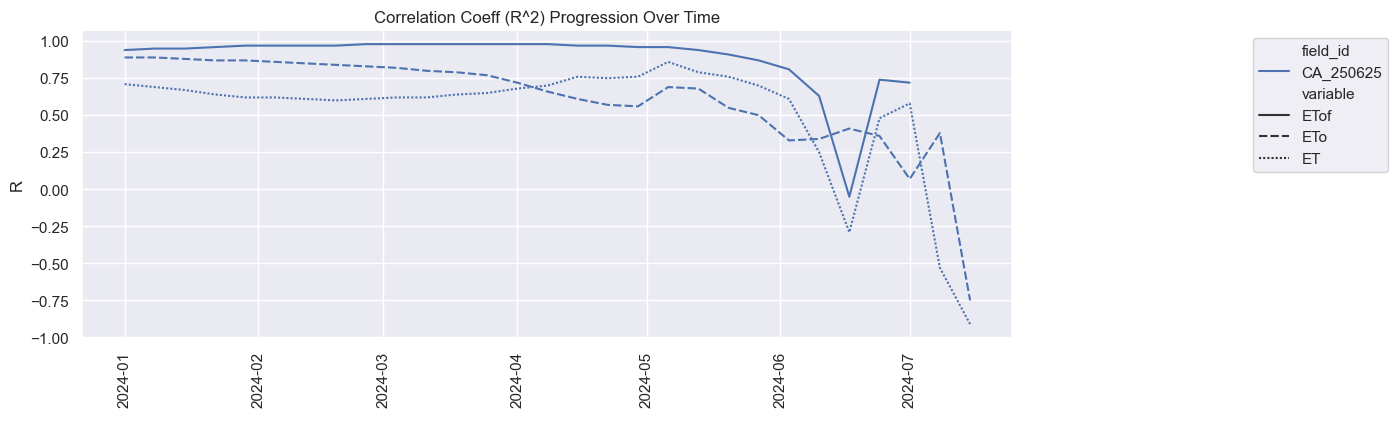

In [32]:
timeseries_plot(corr_plotter, x='forecasting_date', y_a='corr',
                hue='field_id', title='Correlation Coeff (R^2) Progression Over Time', style='variable',
                xlabel=' ', ylabel='R', figsize=(12, 4));

C:\Users\Robin Fishman\AppData\Local\Temp\ipykernel_11820\1260547820.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


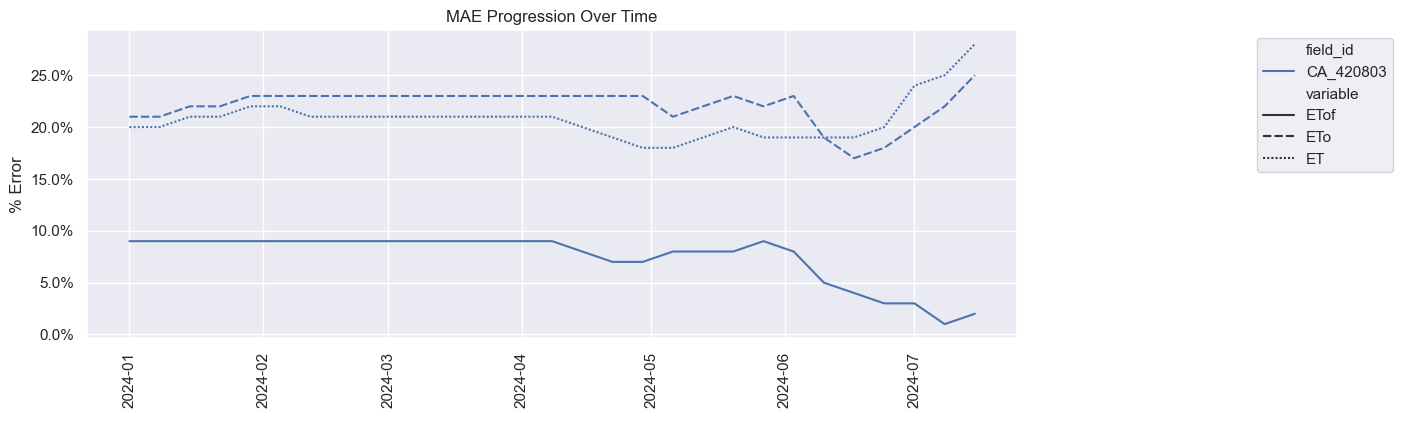

In [33]:
timeseries_plot(mae_plotter, x='forecasting_date', y_a='mae',
                hue='field_id', title='MAE Progression Over Time', style='variable',
                xlabel=' ', ylabel='% Error', as_percent=True, figsize=(12, 4));

C:\Users\Robin Fishman\AppData\Local\Temp\ipykernel_11820\1260547820.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


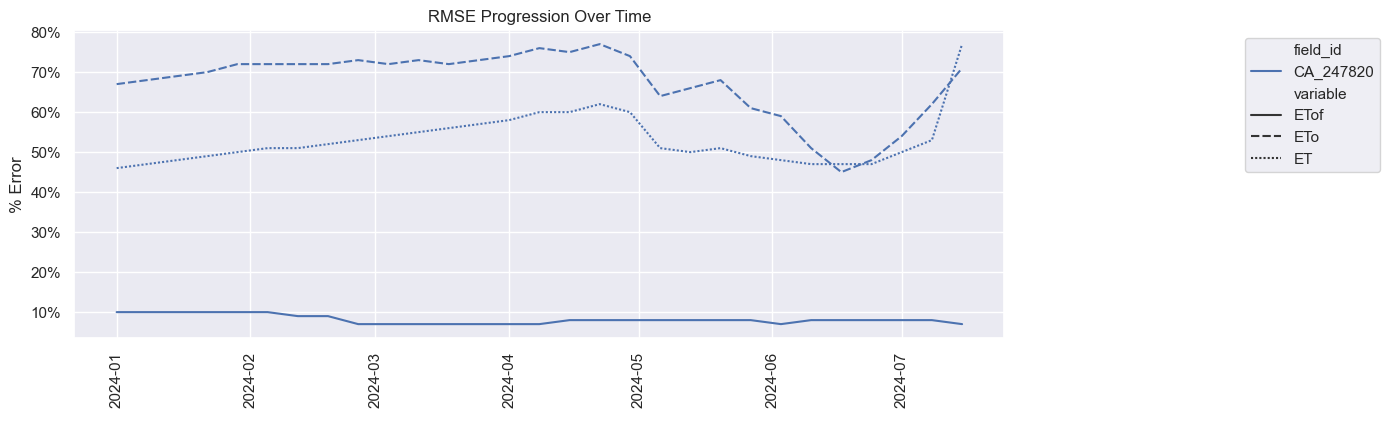

In [34]:
timeseries_plot(rmse_plotter, x='forecasting_date', y_a='rmse',
                hue='field_id', title='RMSE Progression Over Time', style='variable',
                xlabel=' ', ylabel='% Error', as_percent=True, figsize=(12, 4));

C:\Users\Robin Fishman\AppData\Local\Temp\ipykernel_11820\1260547820.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


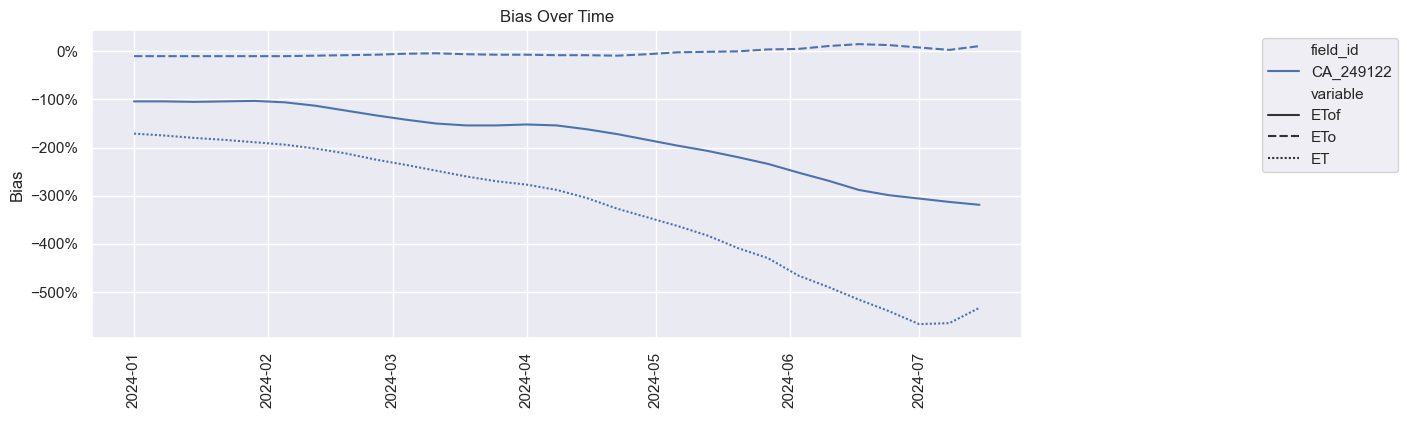

In [35]:
timeseries_plot(bias_plotter, x='forecasting_date', y_a='bias',
                hue='field_id', title='Bias Over Time', style='variable',
                xlabel=' ', ylabel='Bias', as_percent=True, figsize=(12, 4));

C:\Users\Robin Fishman\AppData\Local\Temp\ipykernel_11820\1260547820.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


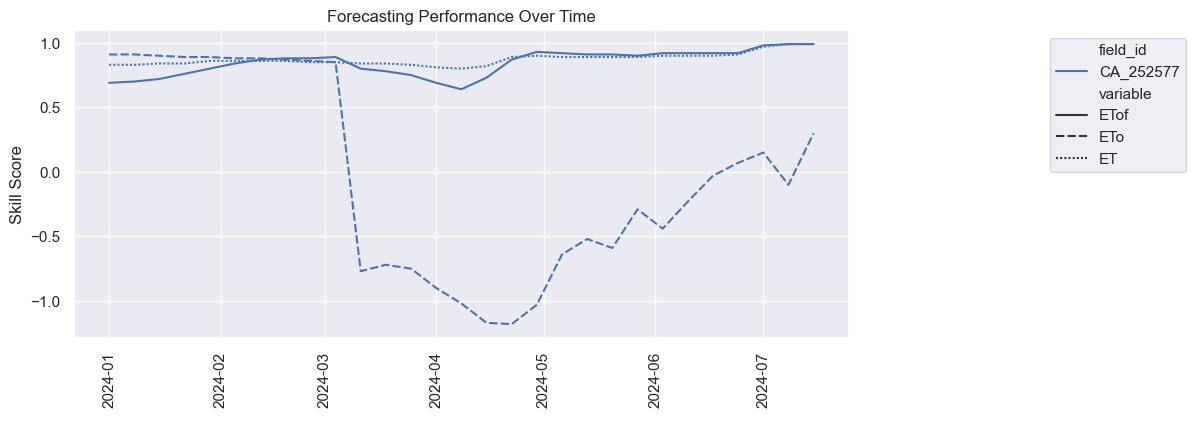

In [36]:
timeseries_plot(ss_plotter, x='forecasting_date', y_a='skill_score',
                hue='field_id', title='Forecasting Performance Over Time', style='variable',
                xlabel=' ', ylabel='Skill Score', figsize=(10, 4));

## Metric ranges

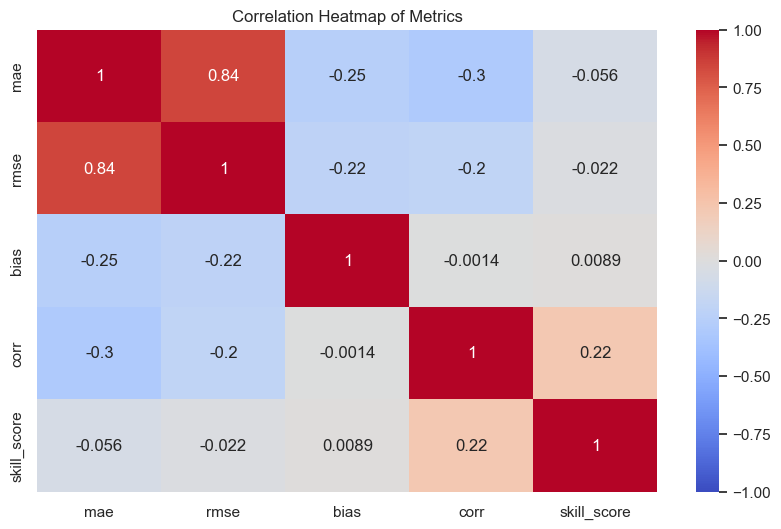

In [37]:
plt.figure(figsize=(10, 6))
metrics = ['mae', 'rmse', 'bias', 'corr', 'skill_score']
corr_matrix = metrics_norm[metrics].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Metrics')
plt.show()

### Timeseries Average using Standard Deviation

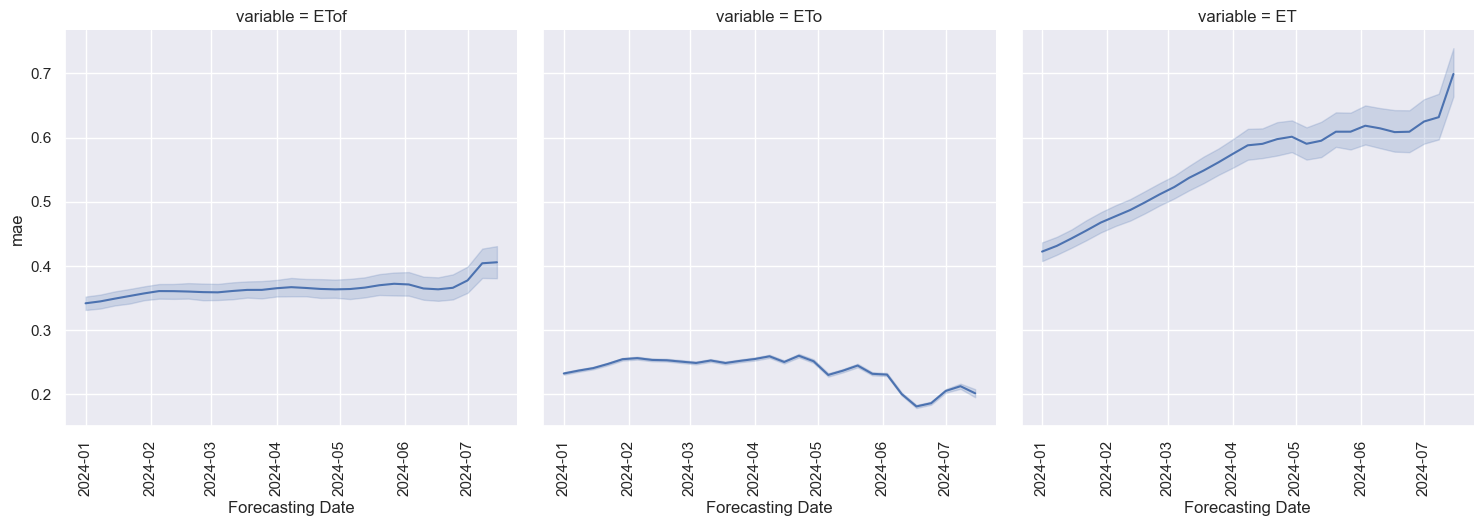

In [39]:
timeseries_rel(metrics_norm, y='mae', col='variable', title='MAE Average Over Time (95%)')

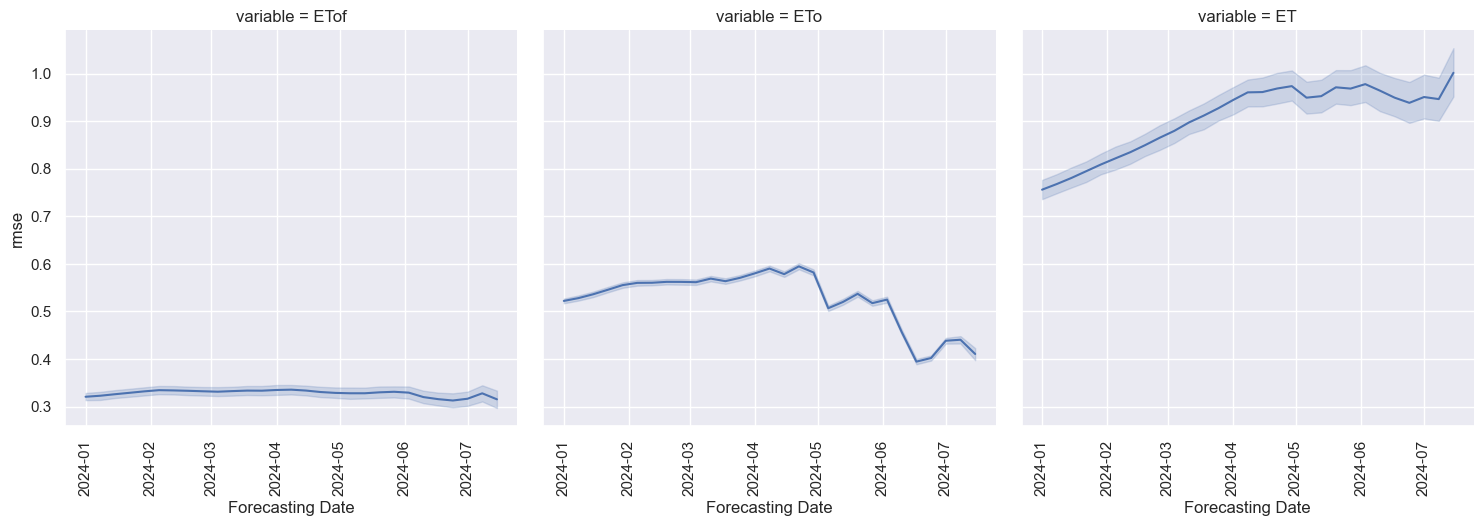

In [40]:
timeseries_rel(metrics_norm, y='rmse', col='variable', title='RMSE Average Over Time (95%)')

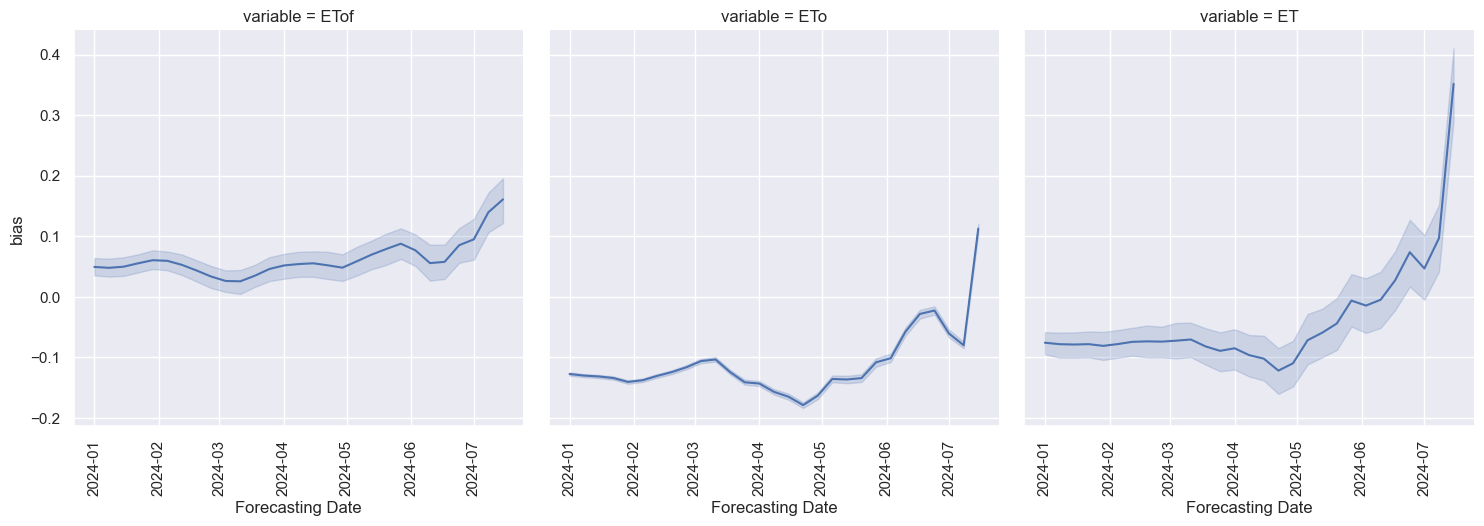

In [41]:
timeseries_rel(metrics_norm, y='bias', col='variable', title='Bias Average Over Time (95%)', errorbar="sd")

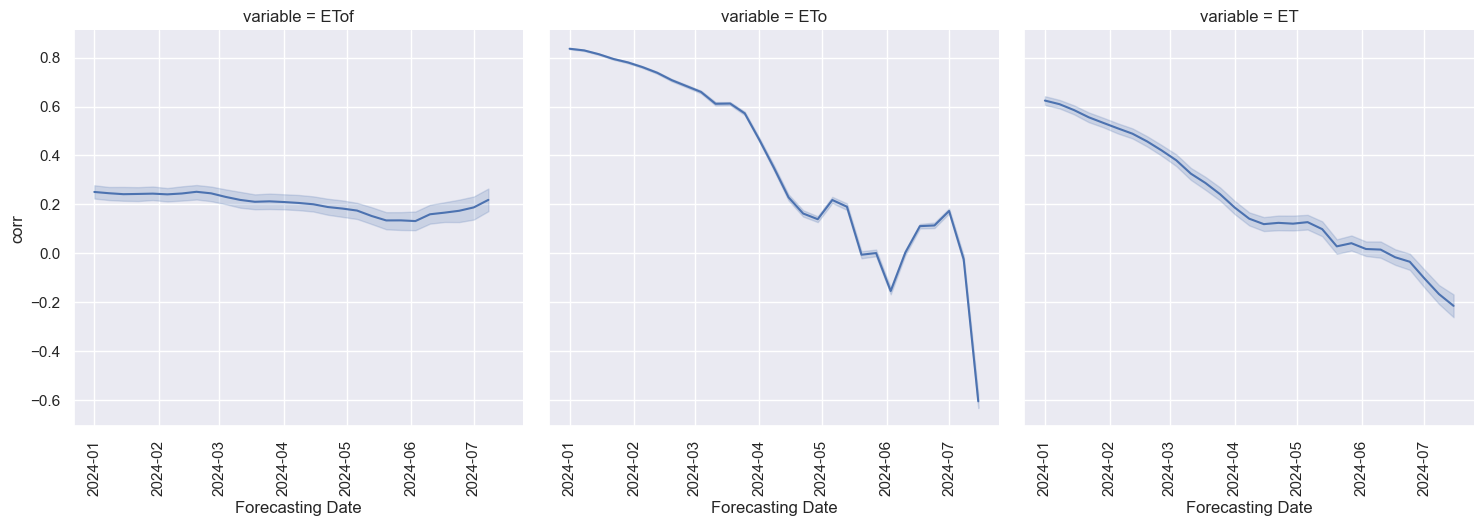

In [42]:
timeseries_rel(metrics_norm, y='corr', col='variable', title='Corr Average Over Time (95%)')

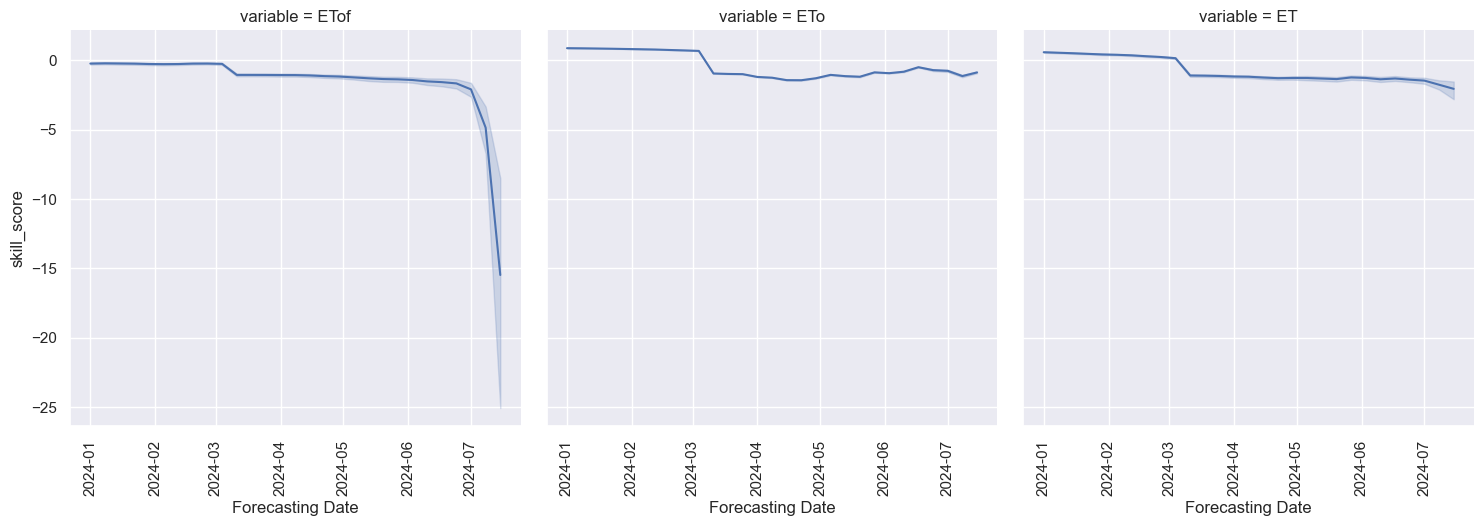

In [43]:
timeseries_rel(metrics_norm, y='skill_score', col='variable', title='Skill Score Average Over Time (95%)')

### Distribution of Metrics

In [69]:
# First reshape data from wide-form to long-form
metrics_long = metrics_norm.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'rmse', 'bias', 'corr', 'skill_score'], var_name='stat')
metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321465 entries, 0 to 321464
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   field_id          321465 non-null  object        
 1   crop              321465 non-null  object        
 2   forecasting_date  321465 non-null  datetime64[ns]
 3   variable          321465 non-null  object        
 4   stat              321465 non-null  object        
 5   value             320719 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 14.7+ MB


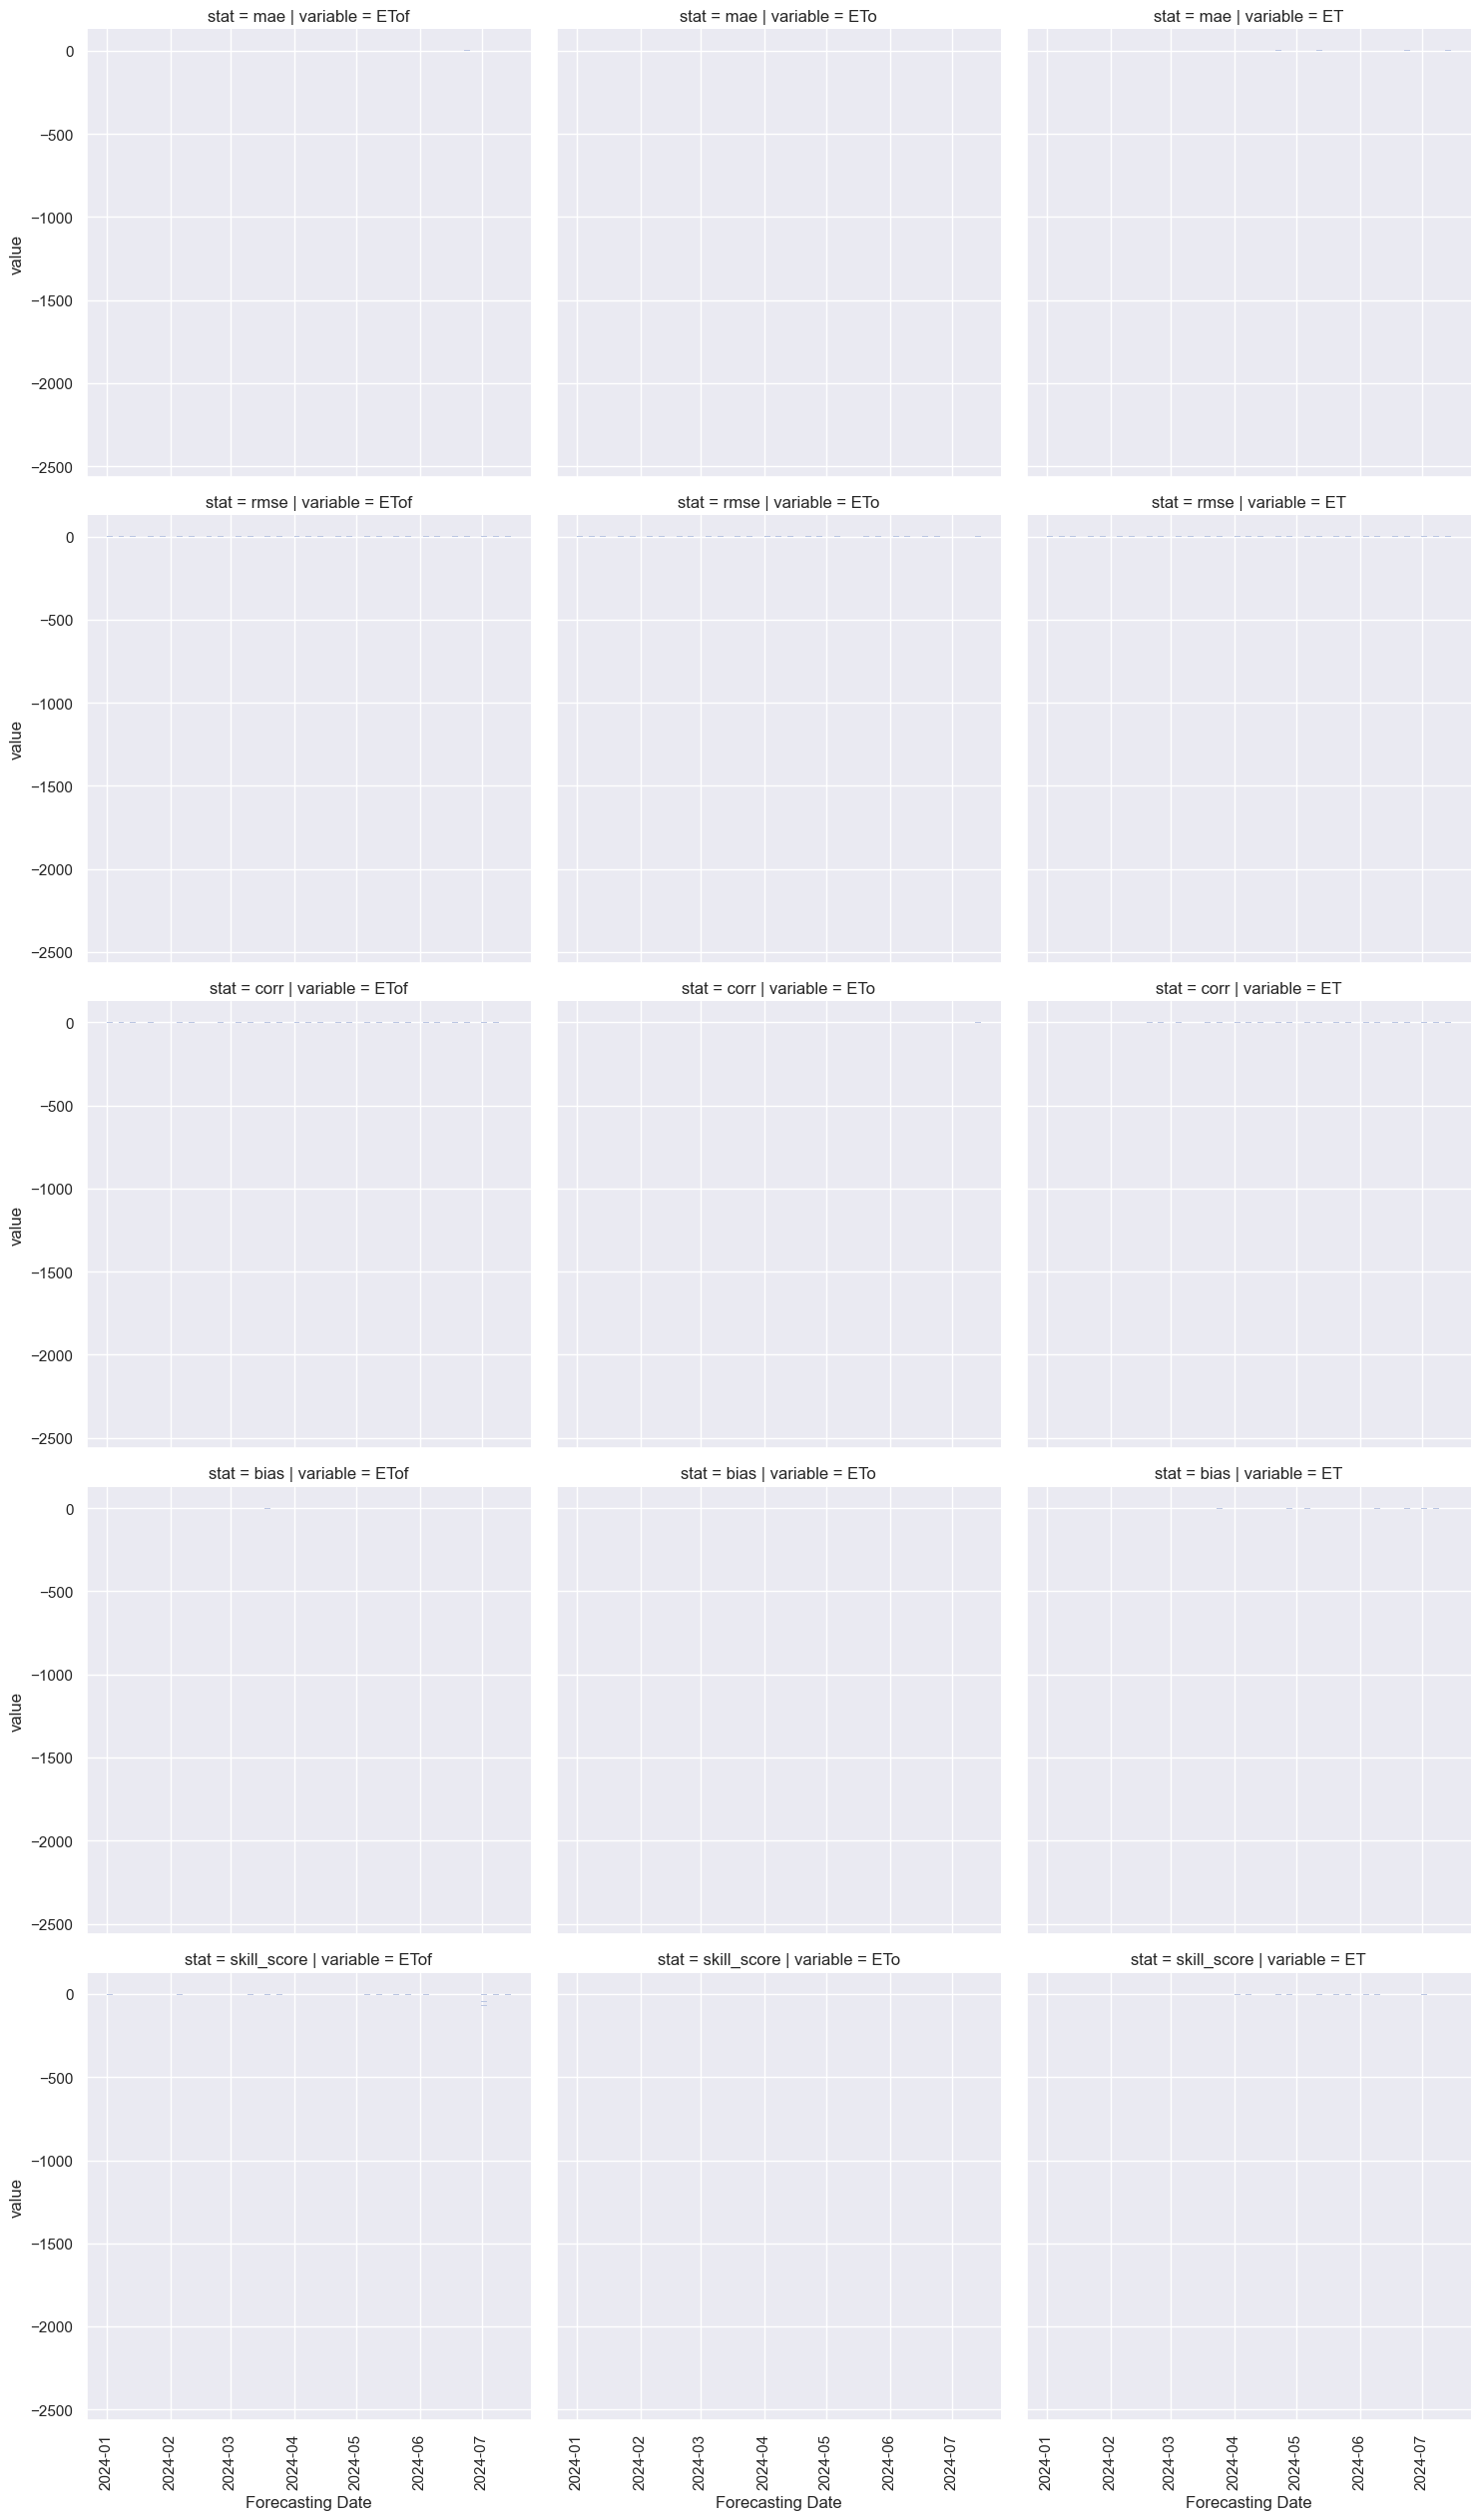

In [76]:
timeseries_rel(metrics_long, type='dis', kind='hist', stat='percent', 
               y='value', col='variable', row='stat',
               title='PDF Distribution of Metrics by Variable')

## Spatial Plotting

### Preparation

First merge the geo table created in the beginning with the metrics table.

Afterwards, get the average metrics amongst all forecasts.

In [45]:
avg_metrics = metrics_norm.groupby('field_id')[['mae', 'rmse', 'bias', 'corr', 'skill_score']].agg('mean')
avg_metrics = avg_metrics.join(monterey_geo, how='left', on='field_id', validate='many_to_one')
avg_metrics

,mae,rmse,bias,corr,skill_score,longitude,latitude
field_id,,,,,,,
CA_244000,0.482644,0.79908,0.096207,0.010349,-0.745057,-121.540540,36.537255
CA_244018,0.512069,0.715977,-0.113563,-0.041628,-1.127471,-121.539709,36.547528
CA_244025,0.330575,0.52023,-0.145402,0.465,-0.072644,-121.505099,36.553781
CA_244035,0.311494,0.473333,0.136782,0.334302,0.103448,-121.767095,36.532256
CA_244053,0.434253,0.589655,-0.248966,0.150116,-1.950805,-121.543673,36.553406
...,...,...,...,...,...,...,...
CA_420824,0.182759,0.381724,-0.043908,0.385698,-0.281264,-121.462685,36.448924
CA_420843,0.224138,0.401724,-0.105747,0.449535,-0.229655,-121.054807,36.161689
CA_420876,0.404253,0.664483,-0.343448,0.407326,-7.107586,-121.472924,36.450659


### Import regional polygon

In [46]:
moco_geo = gpd.read_file("./data/geo/MoCo_Boundary.geojson")
moco_geo

,FID,PERIMETER,COUNTY,SHAPE_AREA,SHAPE_LEN,geometry
0,1,1903900,MONTEREY CO,9.239835e+10,2.155890e+06,"POLYGON ((-121.69858 36.91670, -121.70104 36.9..."


# County Overlays

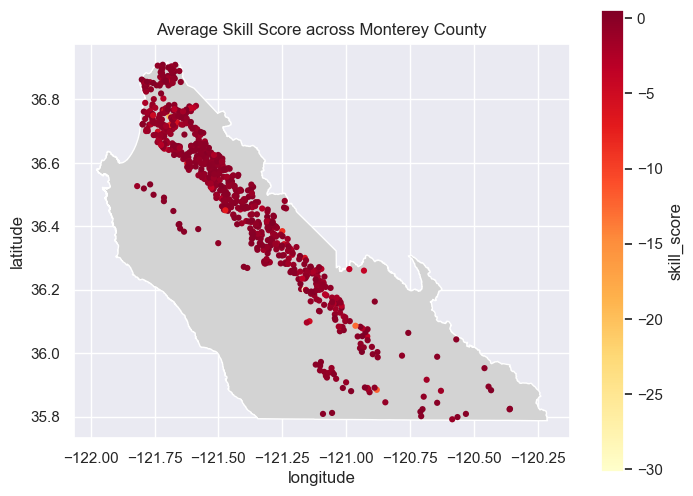

In [47]:
fig, ax = plt.subplots(figsize=(8,6))
moco_geo.plot(color="lightgrey", ax=ax);
avg_metrics.plot(x="longitude", y="latitude", kind="scatter", c="skill_score",
                 title="Average Skill Score across Monterey County", colormap="YlOrRd", linewidths=0, ax=ax);

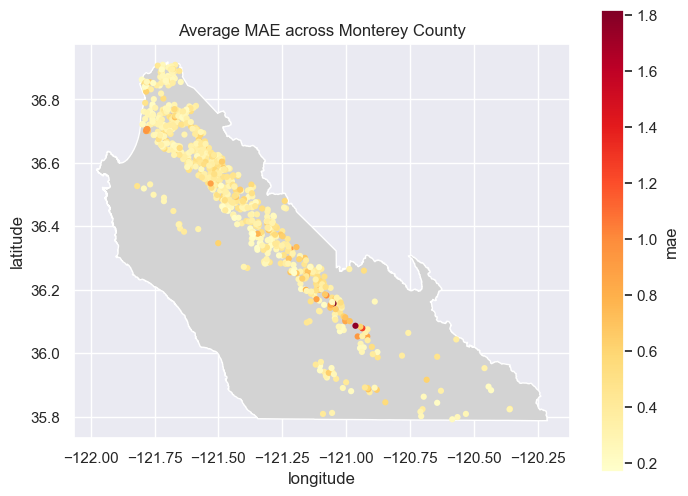

In [48]:
fig, ax = plt.subplots(figsize=(8,6))
moco_geo.plot(color="lightgrey", ax=ax);
avg_metrics.plot(x="longitude", y="latitude", kind="scatter", c="mae",
                 title="Average MAE across Monterey County", colormap="YlOrRd", linewidths=0, ax=ax);

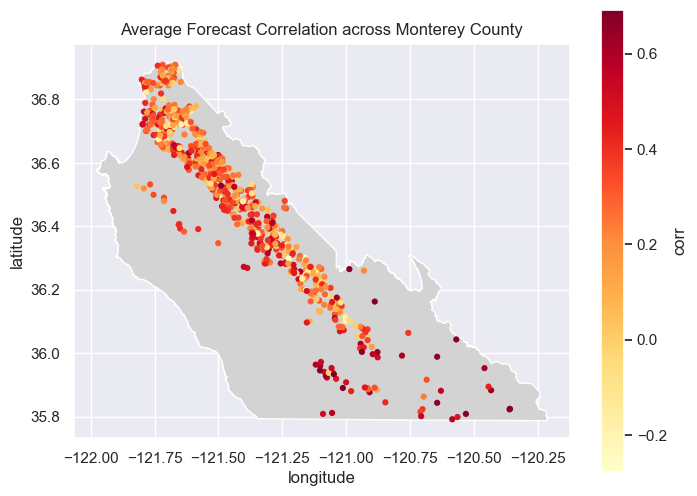

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
moco_geo.plot(color="lightgrey", ax=ax);
avg_metrics.plot(x="longitude", y="latitude", kind="scatter", c="corr",
                 title="Average Forecast Correlation across Monterey County", colormap="YlOrRd", linewidths=0, ax=ax);

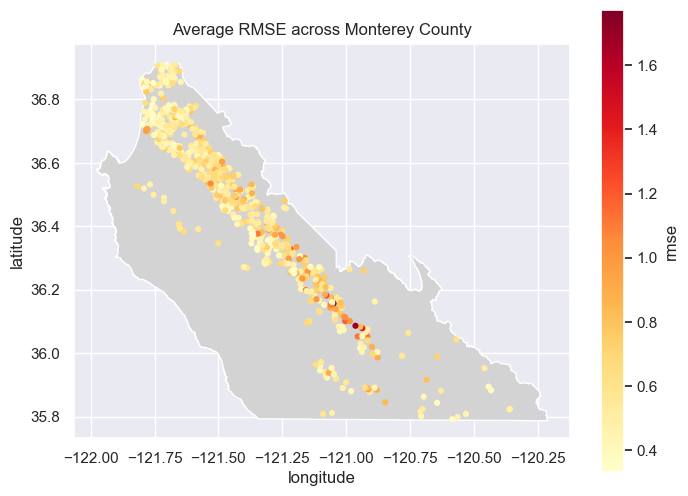

In [50]:
fig, ax = plt.subplots(figsize=(8,6))
moco_geo.plot(color="lightgrey", ax=ax);
avg_metrics.plot(x="longitude", y="latitude", kind="scatter", c="rmse",
                 title="Average RMSE across Monterey County", colormap="YlOrRd", linewidths=0, ax=ax);

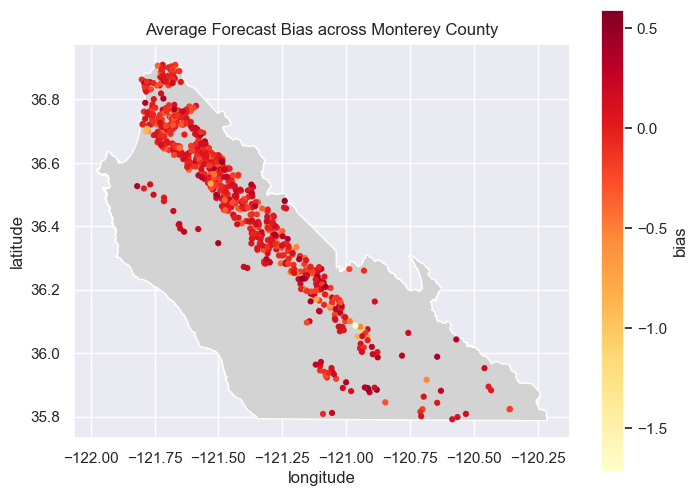

In [51]:
fig, ax = plt.subplots(figsize=(8,6))
moco_geo.plot(color="lightgrey", ax=ax);
avg_metrics.plot(x="longitude", y="latitude", kind="scatter", c="bias",
                 title="Average Forecast Bias across Monterey County", colormap="YlOrRd", linewidths=0, ax=ax);